In [3]:
import random
import os
from os.path import splitext
import csv
from pydub import AudioSegment, utils
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

INPUT_FOLDER = f"{os.getcwd()}/input"
OUTPUT_FOLDER = f"{os.getcwd()}/output"

VALID_AUDIO_EXTENSIONS =('.mp3', '.wav', '.flac', '.ogg', '.m4a', '.aac')
# get list of audio files in a folder ignoring any other files to prevent errors
def getListOfAudioFilesInFolder(folder_path):
  file_list = [file for file in os.listdir(folder_path) if file.endswith(VALID_AUDIO_EXTENSIONS)]
  return file_list

# Takes in a single audio clip and splits it into multiple clips of 10 seconds each.
def split_audio_into_windows(audio, window_duration=10000):
  windows = []
  audio_duration = len(audio)

  for start_time in range(0, audio_duration, window_duration):
    end_time = start_time + window_duration
    window = audio[start_time:end_time]
    windows.append(window)

  return windows

# Insert the gunshot audio into the background audio at a random interval.
def random_insertion(background_audio, gunshot_audio):
  try:
    # If gunshot_audio can fit, proceed with insertion
    if len(gunshot_audio) <= len(background_audio):
      start_time = random.randint(0, len(background_audio) - len(gunshot_audio))
      result = background_audio.overlay(gunshot_audio, position=start_time)

      return result
  except ValueError as e:
    # Ignore this case and return None
    print(f"Ignoring error: {e}")
    return

# Generate a spectrogram for the audio file and save it to the output file.
def generate_spectrogram(audio_segment, output_file, label):
  temp_audio = f"{OUTPUT_FOLDER}/audio/{output_file}.mp3"
  audio_segment.export(temp_audio, format="mp3")
 
  samples = librosa.load(temp_audio, sr=audio_segment.frame_rate)[0]
  # Z-normalize the samples 
  # samples = (samples - np.mean(samples)) / np.std(samples)
  # Use librosa to compute a spectrogram
  spectrogram = librosa.feature.melspectrogram(y=samples, sr=audio_segment.frame_rate)
  # Convert amplitude to decibels
  log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

  # Plot and save the spectrogram
  plt.figure(figsize=(10, 4))
  librosa.display.specshow(log_spectrogram, sr=audio_segment.frame_rate, x_axis='time', y_axis='linear')
  # plt.colorbar(format='%+2.0f dB')
  plt.axis('off')
  plt.savefig(f"{OUTPUT_FOLDER}/spectrograms/{output_file}", bbox_inches='tight', pad_inches=0)
  add_label_csv(output_file, label)
  # plt.show()
  os.remove(temp_audio)
  plt.close()

def add_label_csv(file_name, label):
  file_exists = os.path.isfile(f"{OUTPUT_FOLDER}/labels.csv")
  with open(f"{OUTPUT_FOLDER}/labels.csv", 'a', newline='') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=["file_name", "label"])

    if not file_exists: # Write header only if file does not exist
      writer.writeheader()

    writer.writerow({"file_name": file_name, "label": label})

# Create multiple variations of gunshot-inserted audio files.
def create_variations(window_duration=10000):
  """
    Each background audio file is split into windows of 10 seconds each.
    Each window is inserted with a real (1) or fake (0) gunshot audio.
    Each gunshot audio is inserted at 3 different volume levels (8%, 35%, 70%).
    Finally, each audio permutation (window x gun x volume) is exported as an spectrogram image.
  """
  background_folder = f"{INPUT_FOLDER}/background"
  gunshot_folder = f"{INPUT_FOLDER}/gunshot"
  non_gunshot_folder = f"{INPUT_FOLDER}/non-gunshot"
  background_files = getListOfAudioFilesInFolder(background_folder)
  gunshot_files = getListOfAudioFilesInFolder(gunshot_folder)
  non_gunshot_files = getListOfAudioFilesInFolder(non_gunshot_folder)

  for bg_file_name in background_files:
    bg_file_path = os.path.join(background_folder, bg_file_name)
    bg_audio = AudioSegment.from_file(bg_file_path)
    
    for i, window in enumerate(split_audio_into_windows(bg_audio, window_duration)):
      # Select a gunshot within 80% chance, otherwise select a non-gunshot
      include_gunshot = True
      if random.random() <= 0.8:
        selected_gunshot = random.choice(gunshot_files)
        gunshot_audio = AudioSegment.from_file(os.path.join(gunshot_folder, selected_gunshot))
      else: # 20% chance of selecting a non-gunshot
        include_gunshot = False
        selected_gunshot = random.choice(non_gunshot_files)
        gunshot_audio = AudioSegment.from_file(os.path.join(non_gunshot_folder, selected_gunshot))
      
      # Normalize the audio segments to prevent clipping
      window = window.normalize()
      gunshot_audio = gunshot_audio.normalize()
      
      window_name = f"{splitext(bg_file_name)[0]}_window={i+1}"

      # Generate a clean spectrogram (the original background window without a gunshot)
      generate_spectrogram(window, f"{window_name}_gun=0.png", 0)
      
      # Insert the gunshot into the background window and create different copies for each volume level
      for volume in [0.08, 0.35, 0.70]:
        modified_gunshot = gunshot_audio.apply_gain(utils.ratio_to_db(volume))
        result_audio = random_insertion(window, modified_gunshot)
        
        if result_audio is not None:
          result_audio = result_audio.normalize()
          label = 1 if include_gunshot else 0
          output_filename = f"{window_name}_vol={int(volume * 100)}%_gun={label}"
          
          # Export result audio as mp3
          # result_audio.export(f"{OUTPUT_FOLDER}/audio/{output_filename}.mp3", format="mp3")
          # Generate the spectrogram for the result audio
          generate_spectrogram(result_audio, f"{output_filename}.png", label)


In [ ]:
# RUN
create_variations()

# Loading spetrogram dataset into pytorch

### Peeking into the labels data frame

In [4]:
import pandas as pd

SPECTROGRAMS_FOLDER = f"{OUTPUT_FOLDER}/spectrograms"
data_frame = pd.read_csv(f"{OUTPUT_FOLDER}/labels.csv")

print(data_frame.head(), '\n')
print(data_frame['label'].value_counts().rename(index={0: 'No gun/Fake gun (0)', 1: 'Real gun (1)'}))

                                     file_name  label
0          southcentre_mall_window=1_gun=0.png      0
1   southcentre_mall_window=1_vol=8%_gun=1.png      1
2  southcentre_mall_window=1_vol=35%_gun=1.png      1
3  southcentre_mall_window=1_vol=70%_gun=1.png      1
4          southcentre_mall_window=2_gun=0.png      0 

label
Real gun (1)           6855
No gun/Fake gun (0)    4677
Name: count, dtype: int64


### Creating a custom dataset for the train_loader and test_loader

In [6]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from PIL import Image

class CustomDataset(Dataset):
  def __init__(self, data_frame=None, transform=None):
    self.data_frame = data_frame
    self.transform = transform

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, idx):
    img_name = self.data_frame.iloc[idx, 0]
    image = Image.open(f'{SPECTROGRAMS_FOLDER}/{img_name}').convert('RGB')
    label = int(self.data_frame.iloc[idx, 1])

    if self.transform:
        image = self.transform(image)

    return image, label

"""
Resize the image to standard size, most pretrained models use 224x224. 
If we also use this resolution we can experiment with the built-in pretrained models from torchvision.
"""
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

whole_dataset = CustomDataset(data_frame=data_frame, transform=transform)

# Split the dataset into training and testing sets
train_dataset, test_dataset = train_test_split(whole_dataset, test_size=0.2, random_state=42)

# Create DataLoader instances for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### Looking into the dataloaders exactly as pytorch will receive them:

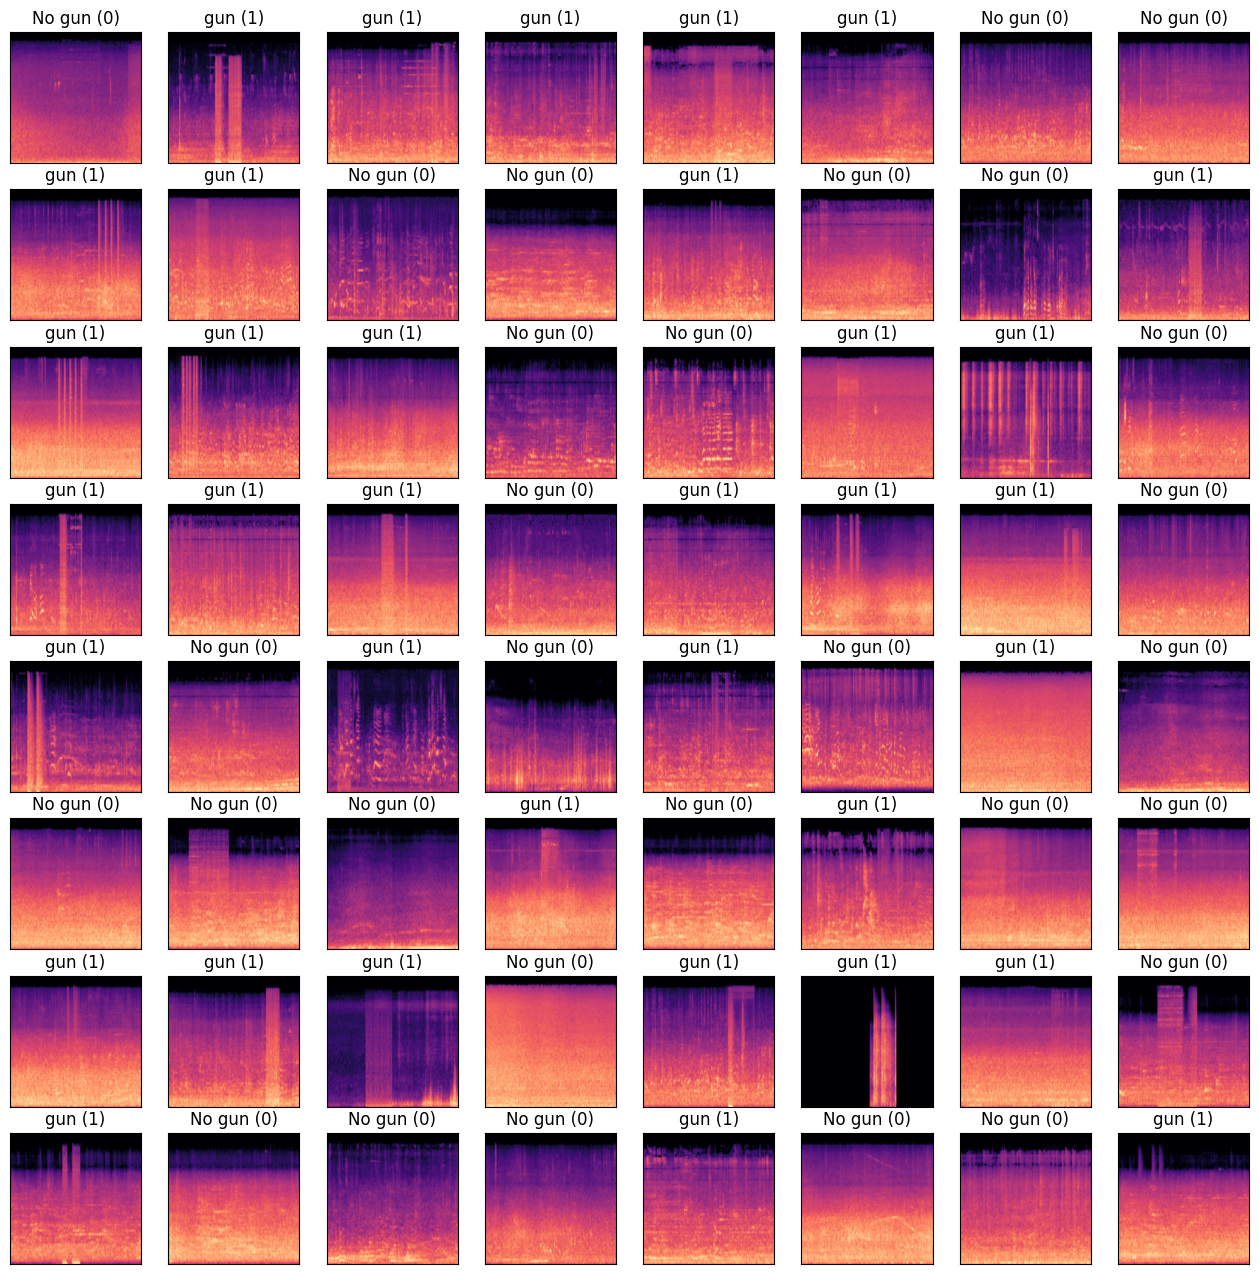

In [7]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot images and labels with no padding
fig = plt.figure(figsize=(16, 16))
for idx in np.arange(64):
  ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(f'{"gun (1)" if labels[idx] == 1 else "No gun (0)"}')
